In [1]:
%matplotlib inline

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging

import workflow
import workflow.source_list
import workflow.ui
import workflow.conf
import workflow.extrude

workflow.ui.setup_logging(1,None)


In [3]:
HUC = '060102020103'
crs = workflow.conf.default_crs()

logging.info("")
logging.info("Meshing HUC: {}".format(HUC))
logging.info("="*30)
logging.info('Target projection: "{}"'.format(crs['init']))
    

2019-07-09 23:27:09,569 - root - INFO: 
2019-07-09 23:27:09,571 - root - INFO: Meshing HUC: 060102020103
2019-07-09 23:27:09,573 - root - INFO: ==============================
2019-07-09 23:27:09,575 - root - INFO: Target projection: "epsg:5070"


In [4]:
sources = workflow.source_list.get_default_sources()
workflow.source_list.log_sources(sources)

2019-07-09 23:27:12,375 - root - INFO: Using sources:
2019-07-09 23:27:12,377 - root - INFO: --------------
2019-07-09 23:27:12,378 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2019-07-09 23:27:12,380 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2019-07-09 23:27:12,381 - root - INFO: DEM: National Elevation Dataset (NED)
2019-07-09 23:27:12,382 - root - INFO: land cover: None
2019-07-09 23:27:12,383 - root - INFO: soil thickness: None
2019-07-09 23:27:12,383 - root - INFO: soil type: None


In [5]:

# collect datasets
huc, centroid = workflow.get_split_form_hucs(sources['HUC'], HUC, crs=crs, centering=False)
rivers, centroid = workflow.get_rivers_by_bounds(sources['hydrography'], 
                                                 huc.exterior().bounds, crs, HUC, centering=centroid)

args = workflow.ui.default_simplify_options()
args.simplify=50
args.prune_reach_size=4
rivers = workflow.simplify_and_prune(huc, rivers, args)
    

2019-07-09 23:27:13,649 - root - INFO: 
2019-07-09 23:27:13,650 - root - INFO: Preprocessing HUC
2019-07-09 23:27:13,652 - root - INFO: ------------------------------
2019-07-09 23:27:13,653 - root - INFO: Loading level 12 HUCs in 060102020103.
2019-07-09 23:27:24,023 - root - INFO: Downloading: "https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/GDB/WBD_06_HU2_GDB.zip"
2019-07-09 23:27:24,024 - root - INFO:          to: "/Users/uec/research/water/data/meshing/examples/data/hydrography/WBD_06_GDB/raw/WBD_06_HU2_GDB.zip"
2019-07-09 23:28:01,930 - root - INFO: Unzipping: "/Users/uec/research/water/data/meshing/examples/data/hydrography/WBD_06_GDB/raw/WBD_06_HU2_GDB.zip"
2019-07-09 23:28:01,932 - root - INFO:        to: "/Users/uec/research/water/data/meshing/examples/data/hydrography/WBD_06_GDB/raw"
2019-07-09 23:28:02,337 - root - INFO: Moving: "/Users/uec/research/water/data/meshing/examples/data/hydrography/WBD_06_GDB/raw/WBD_06_HU2_GDB.gdb"
2019-07-09 23:28:02,338 - 

2019-07-09 23:28:22,032 - root - INFO: 
2019-07-09 23:28:22,035 - root - INFO: Meshing
2019-07-09 23:28:22,038 - root - INFO: ------------------------------
2019-07-09 23:28:22,040 - root - INFO: Triangulating...
2019-07-09 23:28:22,050 - root - INFO:    398 points and 400 facets
2019-07-09 23:28:22,051 - root - INFO:  checking graph consistency
2019-07-09 23:28:22,056 - root - INFO:  building graph data structures
2019-07-09 23:28:22,062 - root - INFO:  triangle.build...
2019-07-09 23:28:30,296 - root - INFO:   ...built: 6782 mesh points and 13212 triangles
2019-07-09 23:28:30,298 - root - INFO: Plotting triangulation diagnostics
2019-07-09 23:28:31,792 - root - INFO: 
2019-07-09 23:28:31,793 - root - INFO: Preprocessing Raster
2019-07-09 23:28:31,793 - root - INFO: ------------------------------
2019-07-09 23:28:31,794 - root - INFO: downloading raster
2019-07-09 23:28:31,797 - root - INFO: Collecting DEMs to tile bounds: (-83.47869992669801, 35.02035285918288, -83.28113437388001, 35

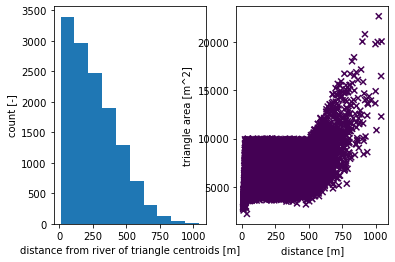

In [6]:
args = workflow.ui.default_triangulate_options()
args.delaunay = False

# triangulation options:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the distance from the triangle
# centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates
# between the two endpoints.
d0 = 500; d1 = 2000
A0 = 10000; A1 = 50000
args.refine_distance = [d0,A0,d1,A1]

# make 2D mesh
mesh_points2, mesh_tris = workflow.triangulate(huc, rivers, args, diagnostics=True)

# get a raster for the elevation map
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], huc.polygon(0), crs)

# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, dem, dem_profile)

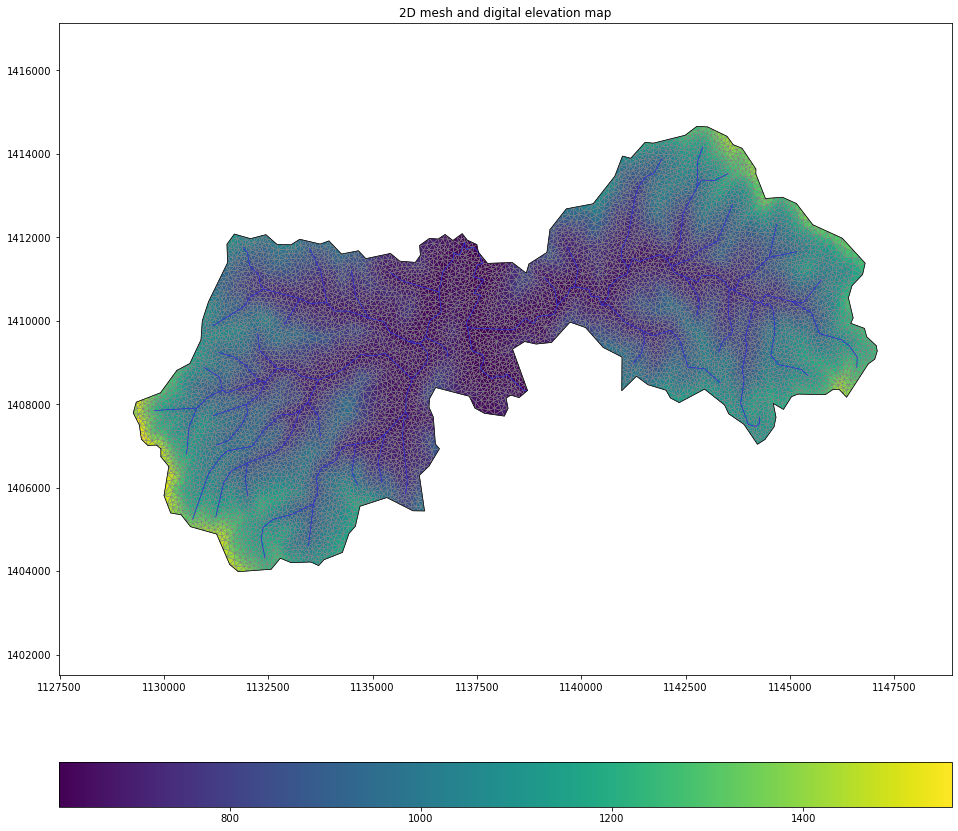

In [7]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, linewidth=0.5, color='elevation')
fig.colorbar(mp, orientation="horizontal", pad=0.1)
workflow.plot.hucs(huc, 'k', linewidth=0.7)
workflow.plot.rivers(rivers, color='blue', linewidth=0.5)
ax.set_aspect('equal', 'datalim')
t = ax.set_title('2D mesh and digital elevation map')

In [8]:
# convert the triangulation into a 2D mesh for extrusion
m2 = workflow.extrude.Mesh2D(mesh_points3, list(mesh_tris))

In [9]:
# imagine we could get the soil and geologic types now...
soil_type = 1001 * np.ones((len(mesh_tris),),'i')
geologic_type = 101 * np.ones((len(mesh_tris),),'i')

In [10]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z = 0.0

# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 9
dz = 0.05
layer_dz = 4

def telescope_factor(ncells, dz, layer_dz):
    """Calculates a telescoping factor"""
    if ncells * dz > layer_dz:
        raise ValueError(("Cannot telescope {} cells of thickness at least {} "+
                          "and reach a layer of thickness {}").format(ncells, dz, layer_dz))

    import scipy.optimize
    def seq(r):
        calc_layer_dz = dz * (1 - r**ncells)/(1-r)
        #print('tried: {} got: {}'.format(r, calc_layer_dz))
        return layer_dz - calc_layer_dz
    res = scipy.optimize.root_scalar(seq, x0=1.0001, x1=2)
    return res.root

tele = telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_type)
    z += dz
    dz *= tele
    
# one more 2m layer makes 6m
dz = 2.0
layer_types.append('constant')
layer_data.append(dz)
layer_ncells.append(1)
layer_mat_ids.append(soil_type)
z += dz

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
layer_types.append("constant")
layer_data.append(40 - z) # depth of bottom of domain is 40 m
layer_ncells.append(int(round(layer_data[-1] / dz)))
layer_mat_ids.append(geologic_type)

# print the summary
workflow.extrude.Mesh3D.summarize_extrusion(layer_types, layer_data, layer_ncells, layer_mat_ids)

2019-07-09 23:30:22,881 - root - INFO: Got telescoping factor: 1.515910144611108
2019-07-09 23:30:22,883 - root - INFO: Cell summary:
2019-07-09 23:30:22,883 - root - INFO: ------------------------------------------------------------
2019-07-09 23:30:22,885 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2019-07-09 23:30:22,887 - root - INFO: ------------------------------------------------------------
2019-07-09 23:30:22,888 - root - INFO:  00 	| 00 	| 1001 	|   0.050000 	|   0.000000
2019-07-09 23:30:22,889 - root - INFO:  01 	| 01 	| 1001 	|   0.075796 	|   0.050000
2019-07-09 23:30:22,890 - root - INFO:  02 	| 02 	| 1001 	|   0.114899 	|   0.125796
2019-07-09 23:30:22,891 - root - INFO:  03 	| 03 	| 1001 	|   0.174177 	|   0.240695
2019-07-09 23:30:22,895 - root - INFO:  04 	| 04 	| 1001 	|   0.264036 	|   0.414872
2019-07-09 23:30:22,897 - root - INFO:  05 	| 05 	| 1001 	|   0.400255 	|   0.678908
2019-07-09 23:30:22,898 - root - INFO:  06 	| 06 	| 1001 	|   0.606751 	|   1.07916

In [11]:
# extrude
m3 = workflow.extrude.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, layer_ncells, layer_mat_ids)

In [12]:
# save to disk
m3.write_exodus('my_mesh.exo')


You are using exodus.py v 1.11 (seacas-beta), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: my_mesh.exo
Closing exodus file: my_mesh.exo
